# 1. What is GWAS?

In [1]:
using DataFrames
using CategoricalArrays # For CategoricalArray
using GLM # For linear models
using Distributions
using HypothesisTests # For ChisqTest
using Plots
using StatsPlots # For grouped bar plot
using Printf

# Default plot settings
gr(html_output_format=:png); # Avoid SVG and forcing PNG format for plots

## 1.1 Genetic variation

### 1.1.2 Genotypes and Hardy-Weinberg equilibrium

##### Example 1.1

In [2]:
geno = [ 66, 29, 4]
n = sum(geno) # number of individuals
f = sum(geno .* [ 0, 1, 2]) / (2 * n) # (66*0 + 29*1 + 4*2) / (2 * (66+29+4))

0.18686868686868688

In [3]:
hwe_prop = [ (1-f)^2, 2*f*(1-f), f^2] # these would be the geno type freqa under HWE
DataFrame(obs = geno/n, hwe = hwe_prop) # print the observed genotype freqs and the HWE

,obs,hwe
,Float64,Float64
1,0.666667,0.661183
2,0.292929,0.303898
3,0.040404,0.0349199


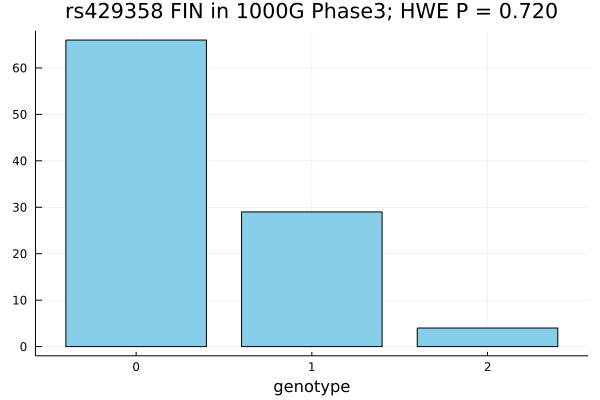

In [4]:
# For testing HWE, we use chi-square test even though counts are quite small in the last row
hwe_test = sum( (geno - n*hwe_prop).^2 ./ (n * hwe_prop)) # HWE test statistic
hwe_p = ccdf(Chisq(1), hwe_test) # P-value from the test

bar(0:2, geno, 
    xaxis=("genotype", 0:2),
    leg=false,
    color="skyblue",
    title=@sprintf("rs429358 FIN in 1000G Phase3; HWE P = %.3f", hwe_p)
)

##### Synthetic Data

In [5]:
n = 1000

sample_from_geno = wsample(0:2, geno, n, replace=true) # sample from genotype frequencies
counts_from_geno = [count(x -> x==i, sample_from_geno) for i ∈ 0:2] # compute the vector of occurences

sample_from_hwe = rand(Binomial(2, f), n) # sample n genotypes from Binomial(2, f)
counts_from_hwe = [count(x -> x==i, sample_from_hwe) for i ∈ 0:2]

DataFrame(geno = counts_from_geno/n, hwe = counts_from_hwe/n)

,geno,hwe
,Float64,Float64
1,0.637,0.663
2,0.314,0.306
3,0.049,0.031


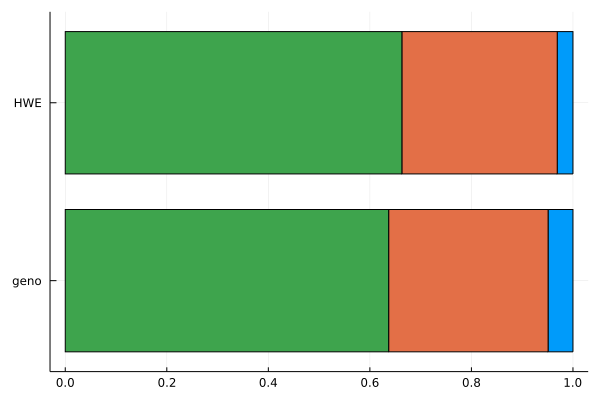

In [6]:
groupedbar(
    ["geno", "HWE"], [reverse(counts_from_geno')/n; reverse(counts_from_hwe)'/n],
    orientation=:h, bar_position=:stack, legend=false, xticks=0:0.2:1
)

In [7]:
df_count_int = DataFrame(
    geno = counts_from_geno/n,
    geno_interval = map(x -> quantile(Beta(x+0.5, n-x+0.5), [0.025, 0.975]), counts_from_geno),
    hwe = counts_from_hwe/n,
    hwe_interval = map(x -> quantile(Beta(x+0.5, n-x+0.5), [0.025, 0.975]), counts_from_hwe),
    copycols=false # use copycols=false to avoid copying data
)

,geno,geno_interval,hwe,hwe_interval
,Float64,Array…,Float64,Array…
1,0.637,"[0.606835, 0.666373]",0.663,"[0.633265, 0.691793]"
2,0.314,"[0.285804, 0.343271]",0.306,"[0.27803, 0.335091]"
3,0.049,"[0.036901, 0.0637033]",0.031,"[0.0215731, 0.0431336]"


In [8]:
ChisqTest([counts_from_geno counts_from_hwe])

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.325, 0.155, 0.02, 0.325, 0.155, 0.02]
    point estimate:          [0.3185, 0.157, 0.0245, 0.3315, 0.153, 0.0155]
    95% confidence interval: [(0.2955, 0.3422), (0.134, 0.1807), (0.0015, 0.0482), (0.3085, 0.3552), (0.13, 0.1767), (0.0, 0.0392)]

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.0967

Details:
    Sample size:        2000
    statistic:          4.673225806451619
    degrees of freedom: 2
    residuals:          [-0.509902, 0.227185, 1.42302, 0.509902, -0.227185, -1.42302]
    std. residuals:     [-1.2189, 0.386785, 2.05396, 1.2189, -0.386785, -2.05396]


## 1.2 What is genome-wide association study?

### 1.2.1 Quantitive traits

In [9]:
n = 10000
f = 0.04
μ = [0.02, -0.40, -2.00] # mean of each genotype
σ = ones(size(μ)) # SD of each genoetype

x = rand(Binomial(2, f), n)
DataFrame([(genotype=i, freq=count(_x->_x==i, x)/n) for i ∈ 0:2])

,genotype,freq
,Int64,Float64
1,0,0.9255
2,1,0.0731
3,2,0.0014


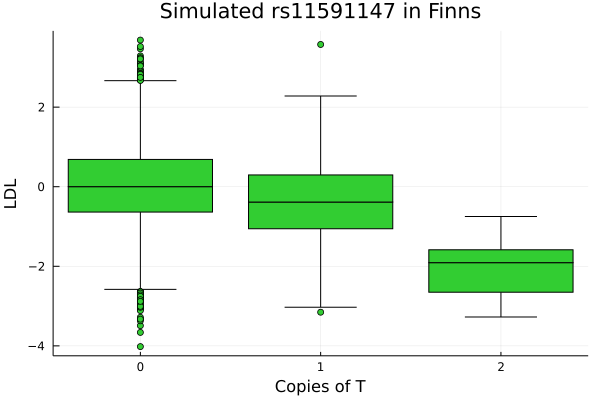

In [10]:
ldl_data = DataFrame(
    "x" => x,
    "y" => μ[x .+ 1] .+ randn(n) .* σ[x .+ 1], # sample LDL levels for genotype,
    copycols=false # use copycols=false to avoid copying data
)
boxplot(ldl_data.x, ldl_data.y, title="Simulated rs11591147 in Finns", 
        ylabel="LDL", xlabel="Copies of T", 
        xticks=0:2,
        color="limegreen", legend=false)

##### Additive model

In [11]:
lm_fit = lm(@formula(y ~ x), ldl_data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.014829   0.0103388    1.43    0.1515  -0.00543713   0.0350951
x            -0.442219   0.0368538  -12.00    <1e-32  -0.51446     -0.369978
─────────────────────────────────────────────────────────────────────────────

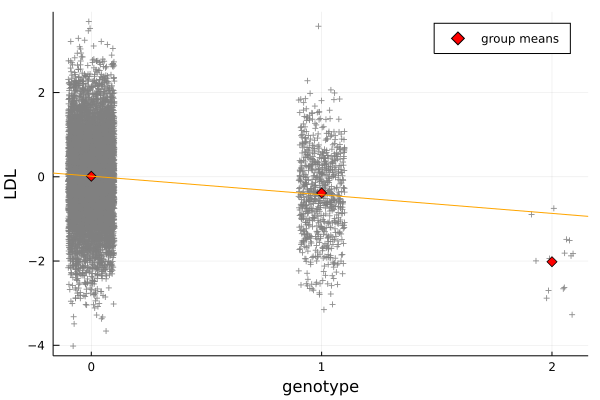

In [12]:
# plot LDL data with some uniform jitter in X-axis
scatter(ldl_data.x .+ 0.20 .* (0.50 .- rand(n)), ldl_data.y,
    xlabel="genotype", ylabel="LDL", label=nothing,
    marker=:+, markersize=3, color="gray", xticks=0:2
)

# plot group means for each genotype
scatter!(0:2, [mean(ldl_data[ldl_data.x .== i, :y]) for i ∈ 0:2],
    markershape=:d, markersize=5, markercolor="red", label="group means"
)

# Plot ab line for the model; Plots.abline() expects coefficients in reverse
# order than that provided by lm()
Plots.abline!(reverse(coef(lm_fit))..., color="orange", label=nothing)

##### Full model

In [13]:
lm_full = lm(
    @formula(y ~ x + z),
    DataFrame(
        "x" => ldl_data.x,
        "y" => ldl_data.y,
        "z" => ldl_data.x .== 2,
        copycols=false # use copycols=false to avoid copying data
    )
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x + z

Coefficients:
────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)    Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   0.013094   0.0103362    1.27    0.2053  -0.00716701   0.033355
x            -0.396552   0.038203   -10.38    <1e-24  -0.471438    -0.321666
z            -1.23654    0.275942    -4.48    <1e-05  -1.77745     -0.695641
────────────────────────────────────────────────────────────────────────────

In [14]:
lm_full2 = lm(
    @formula(y ~ x), 
    DataFrame(
        "x" => CategoricalArray(ldl_data.x),
        "y" => ldl_data.y,
        copycols=false # use copycols=false to avoid copying data
    )
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)    Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   0.013094   0.0103362    1.27    0.2053  -0.00716701   0.033355
x: 1         -0.396552   0.038203   -10.38    <1e-24  -0.471438    -0.321666
x: 2         -2.02965    0.265958    -7.63    <1e-13  -2.55098     -1.50832
────────────────────────────────────────────────────────────────────────────

##### Quantile Normalisation

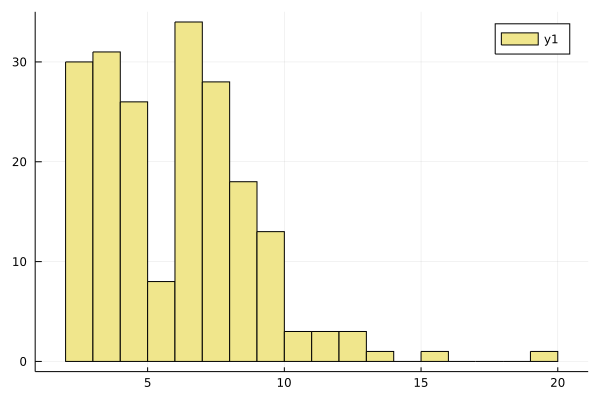

In [15]:
# Generate a phenotype with male following 2 + Γ(shape=1.5, scale=1.5) and females
# following 6 + Γ(shape=1.5, scale=1.5)
n = 200 # males + females
fem = repeat([0, 1], inner=n÷2)
y = 2 .+ 4 .* fem .+ rand(Gamma(1.5, 1.5), n)

histogram(y, bins=30, color="khaki")

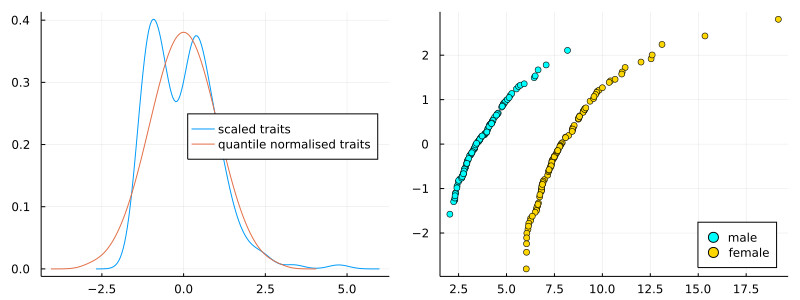

In [16]:
# regress out sex and take residuals
lm_fit = lm(@formula(y ~ fem), DataFrame("fem"=>fem, "y"=>y, copycols=false))
r = residuals(lm_fit)

# find QN'ed trait values from qnorm = inverse of cumulative distribution of Normal
# Implements `rank` function. An alternative is available in StatsBase.jl
function rank(d::AbstractArray; sortkwargs...)
    ord = sortperm(vec(d); sortkwargs...)
    rnk = similar(ord, Int)
    @inbounds for i in 1:size(ord, 1)
        rnk[ord[i]] = i
    end
    return rnk
end
inv_normalise(x) = quantile(Normal(), (rank(r) .- 0.50) ./ size(vec(x), 1))

q = inv_normalise(r)

# define function to scale data
scale_data(d::AbstractArray) = (d .- mean(d, dims=1)) ./ std(d, dims=1)

p = plot(layout=(1, 2), size=(800, 300))
density!(p, scale_data(y), label="scaled traits",legend=:right)
density!(p, scale_data(q), label="quantile normalised traits")
scatter!(p, y[fem.==0], q[fem.==0], color="cyan", label="male", legend=:bottomright, subplot=2)
scatter!(p, y[fem.==1], q[fem.==1], color="gold", label="female", subplot=2)

### 1.2.2 Binary phenotypes

##### Example 1.5

In [17]:
or = 1.43
a_cntrl = 0.13
q = [(1 - a_cntrl)^2, 2a_cntrl*(1 - a_cntrl), a_cntrl^2]
f₀ = (1 + or * q[2]/q[1] + or^2 * q[3]/q[1]) ^ -1
f = [f₀, or * q[2]/q[1] * f₀, or^2 * q[3]/q[1] * f₀]

DataFrame("controls" => q, "cases" => f)

,controls,cases
,Float64,Float64
1,0.7569,0.67888
2,0.2262,0.290124
3,0.0169,0.0309965


In [18]:
n = 2000
x_cases = rand(DiscreteNonParametric(0:2, f), n) # 'Categorical(f)` distribution could also be used with `.- 1`
x_controls = rand(DiscreteNonParametric(0:2, q), n)

x = [x_cases; x_controls]
y = [ones(Integer, n); zeros(Integer, n)]

glm_fit = glm(
    @formula(y ~ x),
    DataFrame("x" => x, "y" => y, copycols=false),
    Binomial()
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.137779   0.0371193  -3.71    0.0002  -0.210532  -0.0650267
x             0.455591   0.0643395   7.08    <1e-11   0.329488   0.581694
──────────────────────────────────────────────────────────────────────────

In [19]:
β = coef(glm_fit)[2] # estimate, beta-hat
l, u = confint(glm_fit)[2,:] # 95% confidence interval
exp.([β, l, u]) # endpoints always on logOR scale, then transform to OR scale

3-element Vector{Float64}:
 1.577104877524092
 1.3902556913622919
 1.7890664358820572

In [20]:
s1 = count(x_cases .== 1); s0 = count(x_cases .== 0); r1 = count(x_controls .== 1); r0 = count(x_controls .== 0)
or_1_counts = (s1/r1) / (s0/r0)
se_1_counts = sqrt(sum((s1, s0, r1, r0) .^ -1))
[or_1_counts, exp(log(or_1_counts) - 1.96*se_1_counts), exp(log(or_1_counts) + 1.96*se_1_counts)]

3-element Vector{Float64}:
 1.5500312204699431
 1.344339472905738
 1.7871950001128962

In [21]:
glm_fit = glm(
    @formula(y ~ x),
    DataFrame("x" => x, "y" => y, copycols=false) |> df -> filter(:x => !=(2), df),
    Binomial()
)
β = coef(glm_fit)[2] # estiamte beta-hat
l, u = confint(glm_fit)[2, :] # 95% confidence intervals
exp.([β, l, u])

3-element Vector{Float64}:
 1.5500312072176592
 1.344346587366369
 1.7871855114799087

In [22]:
glm_full = glm(
    @formula(y ~ x + z),
    DataFrame("x" => x, "y" => y, "z" => x.==2, copycols=false),
    Binomial()
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x + z

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.135123   0.0374767  -3.61    0.0003  -0.208576  -0.0616702
x             0.438275   0.0726375   6.03    <1e-08   0.295908   0.580642
z             0.140959   0.275156    0.51    0.6084  -0.398337   0.680256
──────────────────────────────────────────────────────────────────────────